In [ ]:
url = 'https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files'
ext = '0.4.0-oneiric1_amd64.deb -qO'
!wget $url/libta-lib0_$ext libta.deb
!wget $url/ta-lib0-dev_$ext ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib
!pip install yfinance
!pip install mplfinance
!pip install quandl
!pip install arch

import pandas as pd
import quandl
import yfinance as yf
import openpyxl
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import talib
import matplotlib.pyplot as plt
from matplotlib.pylab import date2num
from mplfinance.original_flavor import candlestick_ohlc
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
from scipy.stats import kstest
from scipy.stats import shapiro 
import math
import statsmodels.api as sm
import seaborn as sns

import os
import sys


import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima.model import ARIMA

from statsmodels.tsa.stattools import adfuller
from arch import arch_model

import statsmodels.api as sm
import scipy.stats as scs
import statsmodels.stats as sms

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [2]:
tickers=['AMC','PLUG','BLK', 'NVDA', 'AMD']
df = yf.download(tickers,
start='2012-1-1',
end='2022-1-1',
progress=False)
data=df['Adj Close']
price = data
lrets = np.log(data/data.shift(1))
data = lrets.dropna()

In [3]:
stock_train = price[:1762]

stock_test = price[1763:]
stock_train

,AMC,AMD,BLK,NVDA,PLUG
Date,,,,,
2012-01-03,NaN,5.480000,136.508499,3.221310,2.00
2012-01-04,NaN,5.460000,135.522003,3.258021,2.02
2012-01-05,NaN,5.460000,135.047531,3.375034,1.98
2012-01-06,NaN,5.430000,134.896942,3.336029,1.93
2012-01-09,NaN,5.590000,134.987259,3.336029,1.86
...,...,...,...,...,...
2018-12-27,11.276551,17.490000,349.900330,32.552219,1.30
2018-12-28,11.479899,17.820000,350.288361,33.167683,1.32
2018-12-31,11.350496,18.459999,354.429779,33.130455,1.24


In [4]:
stock_train_ret = np.log(stock_train/stock_train.shift(1)).dropna()
stock_test_ret = np.log(stock_test/stock_test.shift(1))

stock_test_ret

,AMC,AMD,BLK,NVDA,PLUG
Date,,,,,
2019-01-07,NaN,NaN,NaN,NaN,NaN
2019-01-08,0.031372,0.008713,0.012645,-0.025210,0.044736
2019-01-09,-0.043485,-0.027359,0.005714,0.019476,-0.057894
2019-01-10,-0.015896,-0.022540,-0.001726,0.018415,-0.040546
2019-01-11,0.021615,0.026495,-0.003988,0.024486,0.020479
...,...,...,...,...,...
2021-12-27,0.006292,0.054722,0.009420,0.043087,0.006780
2021-12-28,-0.034743,-0.007870,-0.000813,-0.020338,-0.043853
2021-12-29,0.008263,-0.032450,-0.013213,-0.010643,-0.013146


In [5]:
def _get_best_model(TS):
    best_bic = np.inf 
    best_order = None
    best_mdl = None

    pq_rng = range(5) # [0,1,2,3,4]
    for i in pq_rng:
        for j in pq_rng:
            try:
                tmp_mdl = smt.ARIMA(TS.dropna(), order=(i,0,j)).fit()
                tmp_bic = tmp_mdl.bic
                if tmp_bic < best_bic:
                    best_bic = tmp_bic
                    best_order = (i, 0, j)
                    best_mdl = tmp_mdl
            except: continue
    

    
    #fig = plt.figure(figsize=(10,7))
    pred = best_mdl.predict(start = 1, end = 1762)
    
    print('bic: {:6.5f} | order: {}'.format(best_bic, best_order)) 
                   
    return best_bic, best_order, best_mdl

In [7]:
def tsplot(y, lags=None, figsize=(10, 10), style='ggplot'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)

        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        
        y.plot(ax=ts_ax, label='Prediction', alpha = .9).legend()
        stock_train_ret[i].plot(ax=ts_ax, label = "Exact", alpha = .3).legend()
        
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.2)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.2)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax) 
        


        plt.tight_layout()
    

In [ ]:
stock_test = stock_test.iloc[: , :5]

for i in tickers:
  res = _get_best_model(stock_train.dropna()[i])
  fc, se, conf = res[2].forecast(754)
  k = pd.DataFrame(fc)
  k.index = stock_test.index
  stock_test = pd.merge(stock_test, k, on="Date")
  stock_test

In [9]:
stock_test.columns =['AMC', 'AMD', 'BLK',	'NVDA',	'PLUG', 'pAMC', 'pPLUG', 'pTSLA', 'pNVDA', 'pAMD']

Text(0.5, 1.0, ' Exact and Forcasted Stock Price ')

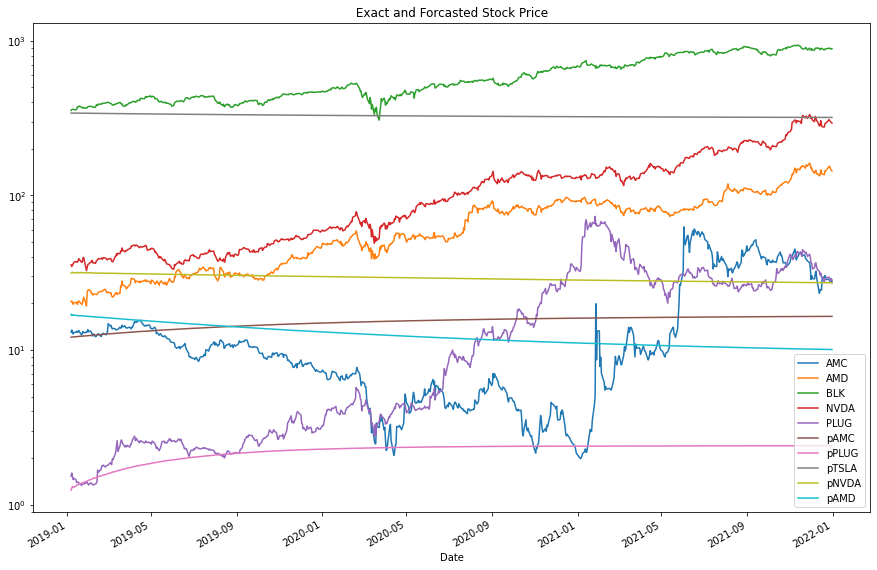

In [10]:
stock_test.plot(figsize = (15, 10))
plt.yscale("log")
plt.title(" Exact and Forcasted Stock Price ")